In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [5]:
%pwd

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/freeze/code/Users/sjin.park977'

In [7]:
train_df = pd.read_csv('/mnt/batch/tasks/shared/LS_root/mounts/clusters/freeze/code/Users/sjin.park977/train_df.csv')

In [8]:
X = train_df[['GRID_X','GRID_Y','Year','Month','Day','Hour','WS','TA_C','HM']]
Y = train_df['ICE_state']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=42)

In [10]:
std = StandardScaler()
std.fit(x_train)
x_train_scaled = std.transform(x_train)
x_test_scaled = std.transform(x_test)

In [10]:
params = {
    'n_estimators':[200,400,600,800,1000],
}

In [11]:
dtc = DecisionTreeClassifier(max_depth=1, random_state=42)
abc = AdaBoostClassifier(estimator=dtc, learning_rate=1.0, random_state=42)

In [12]:
grid_cv = GridSearchCV(abc,param_grid=params,cv=2,n_jobs=2,verbose=2)
grid_cv.fit(x_train_scaled,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ...................................n_estimators=200; total time= 8.3min
[CV] END ...................................n_estimators=400; total time=16.6min
[CV] END ...................................n_estimators=600; total time=25.0min
[CV] END ...................................n_estimators=800; total time=33.6min
[CV] END ..................................n_estimators=1000; total time=40.5min
[CV] END ...................................n_estimators=200; total time= 9.2min
[CV] END ...................................n_estimators=400; total time=16.6min
[CV] END ...................................n_estimators=600; total time=25.0min
[CV] END ...................................n_estimators=800; total time=33.5min
[CV] END ..................................n_estimators=1000; total time=40.4min


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm t

GridSearchCV(cv=2,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                           random_state=42),
                                          random_state=42),
             n_jobs=2, param_grid={'n_estimators': [200, 400, 600, 800, 1000]},
             verbose=2)

In [13]:
grid_cv.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   n_estimators=1000, random_state=42)

In [14]:
estimator = grid_cv.best_estimator_
pred = estimator.predict(x_test_scaled)

In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluation(y_test , pred):
    
    mae = mean_absolute_error(y_test,pred) ## mae
    mse = mean_squared_error(y_test,pred) # mse
    rmse = np.sqrt(mean_squared_error(y_test,pred)) # rmse

    print('mae: {}, mse: {}, rmse:{}'.format(mae, mse, rmse))

In [16]:
print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
evaluation(y_test, pred)

최적 하이퍼 파라미터:
 {'n_estimators': 1000}
최고 예측 정확도: 0.8364
mae: 0.16759336536792402, mse: 0.17573163715254483, rmse:0.41920357483273546


In [17]:
# 중요 특징 시각화
feature_importances = estimator.feature_importances_
features = ['GRID_X','GRID_Y','Year','Month','Day','Hour','WS','TA_C','HM']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

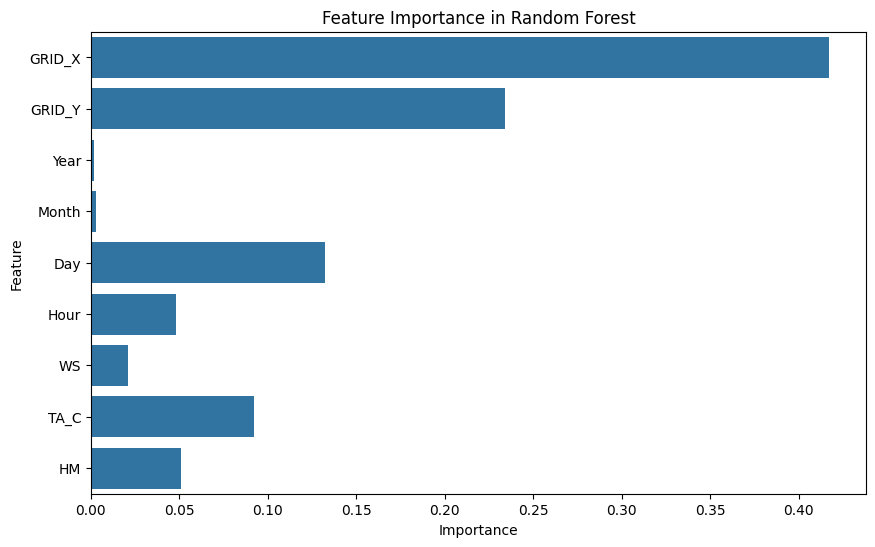

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance',y='Feature',data=importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

In [19]:
import pickle
with open('/mnt/batch/tasks/shared/LS_root/mounts/clusters/freeze/code/Users/sjin.park977/AB_model','wb') as f:
    pickle.dump(estimator,f)

In [5]:
# AdaBoost accuracy 그래프 그리기
import pickle
with open('/mnt/batch/tasks/shared/LS_root/mounts/clusters/freeze/code/Users/sjin.park977/AB_model', 'rb') as f:
    ab_model = pickle.load(f)


In [11]:
# 학습 완료 후 훈련 세트와 검증 세트에서 정확도를 추적
train_acc = accuracy_score(y_train, ab_model.predict(x_train_scaled))
val_acc = accuracy_score(y_test, ab_model.predict(x_test_scaled))

In [12]:
# 정확도 기록
train_accuracies = []
val_accuracies = []

train_accuracies.append(train_acc)
val_accuracies.append(val_acc)

In [13]:
# 차이 계산
accuracy_diff = train_acc - val_acc

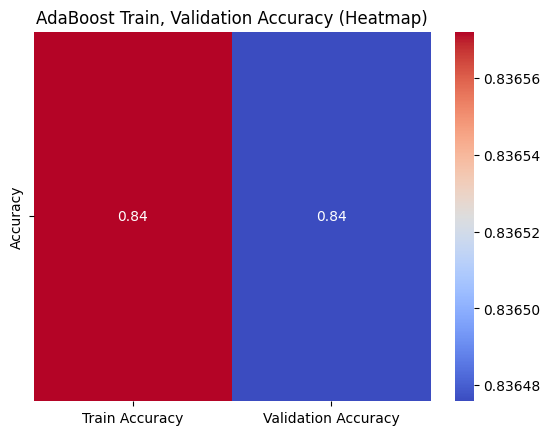

In [14]:
# 정확도를 2D 배열로 준비 (한 차원으로 두 값을 넣음)
accuracy_matrix = np.array([[train_acc, val_acc]])

# 히트맵 그리기
sns.heatmap(accuracy_matrix, annot=True, cmap='coolwarm', xticklabels=['Train Accuracy', 'Validation Accuracy'], yticklabels=['Accuracy'], cbar=True)

# 그래프 설정
plt.title('AdaBoost Train, Validation Accuracy (Heatmap)')

plt.savefig('/mnt/batch/tasks/shared/LS_root/mounts/clusters/freeze/code/Users/sjin.park977/AB_accuracy.png')